##### The latest version of this Jupyter notebook is available at [http://github.com/jckantor/CBE40455](http://github.com/jckantor/CBE20255)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

J.C. Kantor (Kantor.1@nd.edu)

# Binomial Model for Pricing Options

This notebooks demonstrates techniques for pricing options using a binomial lattice to model prices of the underlying security or commodity. The notebook makes use of the pandas_datareader library to download pricing information, and the Pyomo modeling library for some example calculations.

    !pip install pandas_datareader

## Historical Data

The first step is download historical data for a selected security or commodity.  For the purposes of this notebook, it is useful to choose security of commodities for which there is an active options trading so the pricing model can be compared to real data.

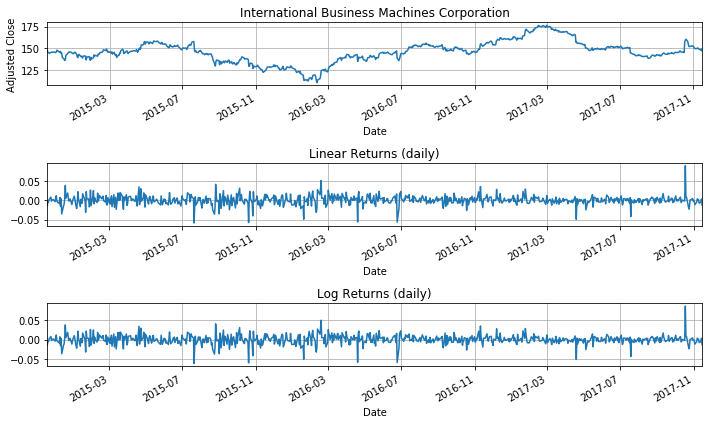

In [248]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import datetime
from pandas_datareader import data, wb

import requests

def get_symbol(symbol):
    """
    get_symbol(symbol) uses Yahoo to look up a stock trading symbol and 
    return a description.
    """
    url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en".format(symbol)
    result = requests.get(url).json()
    for x in result['ResultSet']['Result']:
        if x['symbol'] == symbol:
            return x['name']

symbol = 'IBM'

# end date is today
end = datetime.datetime.today().date()
start = end-datetime.timedelta(3*365)

# get stock price data
P = data.DataReader(symbol,"yahoo",start,end)['Adj Close']

# plot data
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
P.plot(title=get_symbol(symbol))
plt.ylabel('Adjusted Close')
plt.grid()

plt.subplot(3,1,2)
rlin.plot()
plt.title('Linear Returns (daily)')
plt.grid()
plt.tight_layout()

plt.subplot(3,1,3)
rlog.plot()
plt.title('Log Returns (daily)')
plt.grid()
plt.tight_layout()

# Fitting Historical Data to Geometric Brownian Motion

A model for Geometric Brownian Motion can be written in discrete time as

$$S_{t + \Delta t} = S_t + \mu S_t \Delta t + \sigma S_t \sqrt{\Delta t} Z_t $$

where $Z_t$ is a normal random variate with zero mean and a standard deviation of one. This could also be written as 

$$ \ln S_{t + \Delta t} = \ln S_t + \nu \Delta t + \sigma \sqrt{\Delta t} Z_t $$

where $\nu = \mu -\frac{\sigma^2}{2}$. The difference between $\mu$ and $\nu$, i.e.  $\frac{\sigma^2}{2}$, is referred to as 'volatility drag.' 

The parameters can be estimated from trading data as

\begin{align*}
\hat{\mu} & = \frac{1}{\Delta t} \mbox{mean}(\frac{S_{t+\Delta t} - S_t}{S_t}) \\
\hat{\sigma} & = \frac{1}{\sqrt{\Delta t}} \mbox{stdev}(\frac{S_{t+\Delta t} - S_t}{S_t}) \\
\hat{\nu} & = \frac{1}{\Delta t} \mbox{mean}(\ln S_{t+\Delta t} - \ln S_t)
\end{align*}


Note that for trading data time is measured in 'trading days'. On average there are 252 trading days in a year.

| Period | Trading Days |
| :----: | :----------: |
| Year | 252 |
| Quarter | 63 |
| Month | 21 |

In [91]:
from scipy.stats import norm

rlin = (P - P.shift(1))/P.shift(1)
rlog = np.log(P/P.shift(1))

rlin = rlin.dropna()
rlog = rlog.dropna()

print('Linear Returns')
mu,sigma = norm.fit(rlin)
print('   mu = {0:12.8f}  (annualized = {1:.2f}%)'.format(mu,100*252*mu))
print('sigma = {0:12.8f}  (annualized = {1:.2f}%)'.format(sigma,100*np.sqrt(252)*sigma))
print()
print('Log Returns')
nu,sigma = norm.fit(rlog)
print('   nu = {0:12.8f}  (annualized = {1:.2f}%)'.format(nu,100*252*nu))
print('sigma = {0:12.8f}  (annualized = {1:.2f}%)'.format(sigma,100*np.sqrt(252)*sigma))

Linear Returns
   mu =   0.00006975  (annualized = 1.76%)
sigma =   0.01213524  (annualized = 19.26%)

Log Returns
   nu =  -0.00000399  (annualized = -0.10%)
sigma =   0.01214951  (annualized = 19.29%)


## Binomial Model

The binomial model provides a means of modeling the statistical distribution of future prices. Given a current price $S_t$, in the binomial model there are two possible values for the next observed value $S_{t+\Delta t}$

$$S_{t + \Delta t} = \begin{cases} u S_t & \mbox{with probability } p \\ d S_t & \mbox{with probability } 1-p\end{cases}$$

where $u$, $d$, and $p$ are chosen to match the statistics of a model based on Geometric Brownian Motion. 
As shown in [Luenberger (2013)](https://global.oup.com/ushe/product/investment-science-9780199740086?cc=us&lang=en&),

\begin{align*}
p & = \frac{1}{2} + \frac{\nu\Delta t}{2\sqrt{\sigma^2\Delta t + (\nu\Delta t)^2}} \\
\ln u & = \sqrt{\sigma^2\Delta t + (\nu\Delta t)^2} \\
\ln d & = - \sqrt{\sigma^2\Delta t + (\nu\Delta t)^2} 
\end{align*}

In [190]:
# Time/period
dt = 21

p = 0.5 + nu*dt/2/np.sqrt(dt*sigma**2 + (nu*dt)**2)
u = np.exp(np.sqrt(dt*sigma**2 + (nu*dt)**2))
d = np.exp(-np.sqrt(dt*sigma**2 + (nu*dt)**2))

print('Probability (p) = ', round(p,4))
print('  Up Return (u) = ', round(u,4))
print('Down Return (d) = ', round(d,4))

Probability (p) =  0.4992
  Up Return (u) =  1.0573
Down Return (d) =  0.9458


For the purpose of coding, we will use Python dictionaries to store future values of $S$. The future values have two subscripts corresponding to time $t + k\Delta t$ and state $s$. Given $S_{0,0} = S_t$,

\begin{align*}
S_{k + 1, s} & = u S_{k,s} \\
S_{k + 1, s + 1} & = d S_{k,s}
\end{align*}

In [194]:
nPeriods = 6

S = {}
    
S[0,0] = P[-1]
for k in range(0,nPeriods):
    S[k+1,0] = u*S[k,0]
    S[k+1,1] = d*S[k,0]
    for s in range(1,k+1):
        S[k+1,s+1] = d*S[k,s]

# display the binomial tree
for k in range(0,nPeriods+1):
    print('k = ', k,': ',end='')
    for s in range(0,k+1):
        print("({0:d}){1:6.2f}".format(s,S[k,s]),' ',end='')
    print('')

k =  0 : (0)146.97  
k =  1 : (0)155.39  (1)139.01  
k =  2 : (0)164.28  (1)146.97  (2)131.49  
k =  3 : (0)173.69  (1)155.39  (2)139.01  (3)124.36  
k =  4 : (0)183.63  (1)164.28  (2)146.97  (3)131.49  (4)117.63  
k =  5 : (0)194.15  (1)173.69  (2)155.39  (3)139.01  (4)124.36  (5)111.26  
k =  6 : (0)205.27  (1)183.63  (2)164.28  (3)146.97  (4)131.49  (5)117.63  (6)105.23  


## Risk-Neutral Probability

In [231]:
r = 0.0

q = (1+r-d)/(u-d)

K = 120

C = {}

for s in range(0,nPeriods+1):
    C[nPeriods,s] = (max(0,S[nPeriods,s]-K))

for k in reversed(range(0,nPeriods)):
    for s in range(0,k+1):
        C[k,s] = q*C[k+1,s] + (1-q)*C[k+1,s+1]

# display the binomial tree
for k in reversed(range(0,nPeriods+1)):
    print('k = ', k,': ',end='')
    for s in range(0,k+1):
        print("({0:d}){1:6.2f}".format(s,C[k,s]),' ',end='')
    print('')

k =  6 : (0) 85.27  (1) 63.63  (2) 44.28  (3) 26.97  (4) 11.49  (5)  0.00  (6)  0.00  
k =  5 : (0) 74.15  (1) 53.69  (2) 35.39  (3) 19.01  (4)  5.58  (5)  0.00  
k =  4 : (0) 63.63  (1) 44.28  (2) 26.97  (3) 12.11  (4)  2.71  
k =  3 : (0) 53.69  (1) 35.39  (2) 19.33  (3)  7.28  
k =  2 : (0) 44.28  (1) 27.14  (2) 13.14  
k =  1 : (0) 35.47  (1) 19.94  
k =  0 : (0) 27.49  


## Pyomo Implementation


In [232]:
from pyomo.environ import *
import pandas as pd

m = ConcreteModel()

nPeriods = 6
Periods = range(0,nPeriods+1)
States = range(0,nPeriods+1)

m.C = Var(Periods,States,domain=Reals)

m.cons = ConstraintList()

for s in range(0,nPeriods+1):
    m.cons.add(m.C[nPeriods,s] == max(0,S[nPeriods,s]-K))

for k in range(0,nPeriods):
    for s in range(0,k+1):
        m.cons.add(m.C[k,s] == q*m.C[k+1,s] + (1-q)*m.C[k+1,s+1])

m.OBJ = Objective(expr = m.C[0,0], sense=minimize)
SolverFactory('glpk').solve(m)

# display the binomial tree
for k in reversed(range(0,nPeriods+1)):
    print('k = ', k,': ',end='')
    for s in range(0,k+1):
        print("({0:d}){1:6.2f}".format(s,m.C[k,s]()),' ',end='')
    print('')

k =  6 : (0) 85.27  (1) 63.63  (2) 44.28  (3) 26.97  (4) 11.49  (5)  0.00  (6)  0.00  
k =  5 : (0) 74.15  (1) 53.69  (2) 35.39  (3) 19.01  (4)  5.58  (5)  0.00  
k =  4 : (0) 63.63  (1) 44.28  (2) 26.97  (3) 12.11  (4)  2.71  
k =  3 : (0) 53.69  (1) 35.39  (2) 19.33  (3)  7.28  
k =  2 : (0) 44.28  (1) 27.14  (2) 13.14  
k =  1 : (0) 35.47  (1) 19.94  
k =  0 : (0) 27.49  


## Replicating Portfolio

In [233]:
from pyomo.environ import *
import pandas as pd

m = ConcreteModel()

nPeriods = 6
Periods = range(0,nPeriods+1)
States = range(0,nPeriods+1)

# future bond prices
B = {}
for k in Periods:
    B[k] = (1+r)**k

m.C = Var(Periods,Periods,domain=Reals)
m.x = Var(Periods,Periods,domain=Reals)
m.y = Var(Periods,Periods,domain=Reals)

m.cons = ConstraintList()

for k in range(0,nPeriods+1):
    for s in range(0,k+1):
        m.cons.add(m.C[k,s] == m.x[k,s]*S[k,s] + m.y[k,s]*B[k])

for s in range(0,nPeriods+1):
    m.cons.add(m.C[nPeriods,s] >= max(0,S[nPeriods,s] - K))

for k in range(0,nPeriods):
    for s in range(0,k+1):
        m.cons.add(m.x[k,s]*S[k+1,s] + m.y[k,s]*B[k+1] >= m.C[k+1,s])
        m.cons.add(m.x[k,s]*S[k+1,s+1] + m.y[k,s]*B[k+1] >= m.C[k+1,s+1])

m.OBJ = Objective(expr = m.C[0,0], sense=minimize)
SolverFactory('glpk').solve(m)

# display the binomial tree
print('\n Call Option')
for k in range(0,nPeriods+1):
    print('k = ', k,': ',end='')
    for s in range(0,k+1):
        print("{0:6.2f}".format(m.C[k,s]()),' ',end='')
    print('')
    
# display the binomial tree
print('\n Hedge Ratio')
for k in range(0,nPeriods+1):
    print('k = ', k,': ',end='')
    for s in range(0,k+1):
        print("{0:6.2f}".format(m.x[k,s]()),' ',end='')
    print('')
    
# display the binomial tree
print('\n Cash Position')
for k in range(0,nPeriods+1):
    print('k = ', k,': ',end='')
    for s in range(0,k+1):
        print("{0:6.2f}".format(m.y[k,s]()*B[k]),' ',end='')
    print('')


 Call Option
k =  0 :  27.49  
k =  1 :  35.47   19.94  
k =  2 :  44.28   27.14   13.14  
k =  3 :  53.69   35.39   19.33    7.28  
k =  4 :  63.63   44.28   26.97   12.11    2.71  
k =  5 :  74.15   53.69   35.39   19.01    5.58    0.00  
k =  6 :  85.27   63.63   44.28   26.97   11.49    0.00    0.00  

 Hedge Ratio
k =  0 :   0.95  
k =  1 :   0.99    0.90  
k =  2 :   1.00    0.98    0.82  
k =  3 :   1.00    1.00    0.96    0.68  
k =  4 :   1.00    1.00    1.00    0.92    0.43  
k =  5 :   1.00    1.00    1.00    1.00    0.83    0.00  
k =  6 :   0.00    0.00    0.00    0.00    0.00    0.00    0.00  

 Cash Position
k =  0 : -111.88  
k =  1 : -118.43  -105.69  
k =  2 : -120.00  -116.95  -95.05  
k =  3 : -120.00  -120.00  -114.06  -77.07  
k =  4 : -120.00  -120.00  -120.00  -108.44  -47.40  
k =  5 : -120.00  -120.00  -120.00  -120.00  -97.51    0.00  
k =  6 :  85.27   63.63   44.28   26.97   11.49   -0.00   -0.00  


## European Put Option

In [234]:
from pyomo.environ import *
import pandas as pd

m = ConcreteModel()

nPeriods = 6
Periods = range(0,nPeriods+1)
States = range(0,nPeriods+1)

# future bond prices
B = {}
for k in Periods:
    B[k] = (1+r)**k

m.P = Var(Periods,Periods,domain=Reals)
m.x = Var(Periods,Periods,domain=Reals)
m.y = Var(Periods,Periods,domain=Reals)

m.cons = ConstraintList()

for k in range(0,nPeriods+1):
    for s in range(0,k+1):
        m.cons.add(m.P[k,s] == m.x[k,s]*S[k,s] + m.y[k,s]*B[k])

for s in range(0,nPeriods+1):
    m.cons.add(m.P[nPeriods,s] >= max(0,K - S[nPeriods,s]))

for k in range(0,nPeriods):
    for s in range(0,k+1):
        m.cons.add(m.x[k,s]*S[k+1,s] + m.y[k,s]*B[k+1] >= m.P[k+1,s])
        m.cons.add(m.x[k,s]*S[k+1,s+1] + m.y[k,s]*B[k+1] >= m.P[k+1,s+1])

m.OBJ = Objective(expr = m.P[0,0], sense=minimize)
SolverFactory('glpk').solve(m)

# display the binomial tree
print('\n Put Option')
for k in range(0,nPeriods+1):
    print('k = ', k,': ',end='')
    for s in range(0,k+1):
        print("{0:6.2f}".format(m.P[k,s]()),' ',end='')
    print('')
    
# display the binomial tree
print('\n Hedge Ratio')
for k in range(0,nPeriods+1):
    print('k = ', k,': ',end='')
    for s in range(0,k+1):
        print("{0:6.2f}".format(m.x[k,s]()),' ',end='')
    print('')
    
# display the binomial tree
print('\n Cash Position')
for k in range(0,nPeriods+1):
    print('k = ', k,': ',end='')
    for s in range(0,k+1):
        print("{0:6.2f}".format(m.y[k,s]()*B[k]),' ',end='')
    print('')


 Put Option
k =  0 :   0.52  
k =  1 :   0.08    0.93  
k =  2 :   0.00    0.17    1.66  
k =  3 :   0.00    0.00    0.32    2.92  
k =  4 :   0.00    0.00    0.00    0.63    5.08  
k =  5 :   0.00    0.00    0.00    0.00    1.22    8.74  
k =  6 :   0.00    0.00    0.00    0.00    0.00    2.37   14.77  

 Hedge Ratio
k =  0 :  -0.05  
k =  1 :  -0.01   -0.10  
k =  2 :   0.00   -0.02   -0.18  
k =  3 :   0.00    0.00   -0.04   -0.32  
k =  4 :   0.00    0.00    0.00   -0.08   -0.57  
k =  5 :   0.00    0.00    0.00    0.00   -0.17   -1.00  
k =  6 :   0.00    0.00    0.00    0.00    0.00    0.00    0.00  

 Cash Position
k =  0 :   8.12  
k =  1 :   1.57   14.31  
k =  2 :   0.00    3.05   24.95  
k =  3 :   0.00    0.00    5.94   42.93  
k =  4 :   0.00    0.00    0.00   11.56   72.60  
k =  5 :   0.00    0.00    0.00    0.00   22.49  120.00  
k =  6 :  -0.00   -0.00   -0.00   -0.00   -0.00    2.37   14.77  


## American Put Option

In [235]:
from pyomo.environ import *
import pandas as pd

m = ConcreteModel()

nPeriods = 6
Periods = range(0,nPeriods+1)
States = range(0,nPeriods+1)

# future bond prices
B = {}
for k in Periods:
    B[k] = (1+r)**k

m.P = Var(Periods,Periods,domain=Reals)
m.x = Var(Periods,Periods,domain=Reals)
m.y = Var(Periods,Periods,domain=Reals)

m.cons = ConstraintList()

for k in range(0,nPeriods+1):
    for s in range(0,k+1):
        m.cons.add(m.P[k,s] == m.x[k,s]*S[k,s] + m.y[k,s]*B[k])

for s in range(0,nPeriods+1):
    m.cons.add(m.P[nPeriods,s] >= max(0,K - S[nPeriods,s]))

for k in range(0,nPeriods):
    for s in range(0,k+1):
        m.cons.add(m.x[k,s]*S[k+1,s] + m.y[k,s]*B[k+1] >= m.P[k+1,s])
        m.cons.add(m.x[k,s]*S[k+1,s+1] + m.y[k,s]*B[k+1] >= m.P[k+1,s+1])

for k in range(0,nPeriods):
    for s in range(0,k+1):
        m.cons.add(m.x[k,s]*S[k+1,s] + m.y[k,s]*B[k+1] >= K - S[k+1,s])
        m.cons.add(m.x[k,s]*S[k+1,s+1] + m.y[k,s]*B[k+1] >= K - S[k+1,s+1])

m.OBJ = Objective(expr = m.P[0,0], sense=minimize)
SolverFactory('glpk').solve(m)

# display the binomial tree
print('\n Put Option')
for k in range(0,nPeriods+1):
    print('k = ', k,': ',end='')
    for s in range(0,k+1):
        print("{0:6.2f}".format(m.P[k,s]()),' ',end='')
    print('')
    
# display the binomial tree
print('\n Hedge Ratio')
for k in range(0,nPeriods+1):
    print('k = ', k,': ',end='')
    for s in range(0,k+1):
        print("{0:6.2f}".format(m.x[k,s]()),' ',end='')
    print('')
    
# display the binomial tree
print('\n Cash Position')
for k in range(0,nPeriods+1):
    print('k = ', k,': ',end='')
    for s in range(0,k+1):
        print("{0:6.2f}".format(m.y[k,s]()*B[k]),' ',end='')
    print('')


 Put Option
k =  0 :   0.52  
k =  1 :   0.08    0.93  
k =  2 :   0.00    0.17    1.66  
k =  3 :   0.00    0.00    0.32    2.92  
k =  4 :   0.00    0.00    0.00    0.63    5.08  
k =  5 :   0.00    0.00    0.00    0.00    1.22    8.74  
k =  6 :   0.00    0.00    0.00    0.00    0.00    2.37   14.77  

 Hedge Ratio
k =  0 :  -0.05  
k =  1 :  -0.01   -0.10  
k =  2 :   0.00   -0.02   -0.18  
k =  3 :   0.00    0.00   -0.04   -0.32  
k =  4 :   0.00    0.00    0.00   -0.08   -0.57  
k =  5 :   0.00    0.00    0.00    0.00   -0.17   -1.00  
k =  6 :   0.00    0.00    0.00    0.00    0.00    0.00    0.00  

 Cash Position
k =  0 :   8.12  
k =  1 :   1.57   14.31  
k =  2 :   0.00    3.05   24.95  
k =  3 :   0.00    0.00    5.94   42.93  
k =  4 :   0.00    0.00    0.00   11.56   72.60  
k =  5 :   0.00    0.00    0.00    0.00   22.49  120.00  
k =  6 :  -0.00   -0.00   -0.00   -0.00   -0.00    2.37   14.77  
